In [9]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [5]:
%run Functions.ipynb

## Калибровка

## Берём данные с acept_ind1 = 1 и issued_ind = 1. Пропуски в npl1/npl30 оставляем, это не вызревшие кредиты.

In [6]:
filename = 'data/ExcelFile_2021-08-07T11_07_57.xlsx'
card_name = 'Scoring71_new_street_online'

# filename = 'data/ExcelFile_2021-08-07T11_08_13.xlsx'
# card_name = 'Scoring32street_recurring_street'

# filename = 'data/ExcelFile_2021-08-07T11_08_02.xlsx'
# card_name = 'Scoring32mm_recurring_mm'

# filename = 'data/ExcelFile_2021-08-07T11_08_02.xlsx'
# card_name = 'Scoring32mm_recurring_mm'

In [24]:
df = pd.read_excel(filename, engine='openpyxl')
df['date_requested'] = pd.to_datetime(df['date_requested'])
df = df[(df['accept_ind1'] == 1) & (df['issued_ind'] == 1)]

df['score_model'] = df['Scoring71_new'].apply(lambda x: score_model(x))
df_base = df.copy()

df['date_requested'] = df['date_requested'].dt.date
df['strdate_requested'] = df['date_requested'].apply(lambda x: x.strftime('%Y%m%d'))


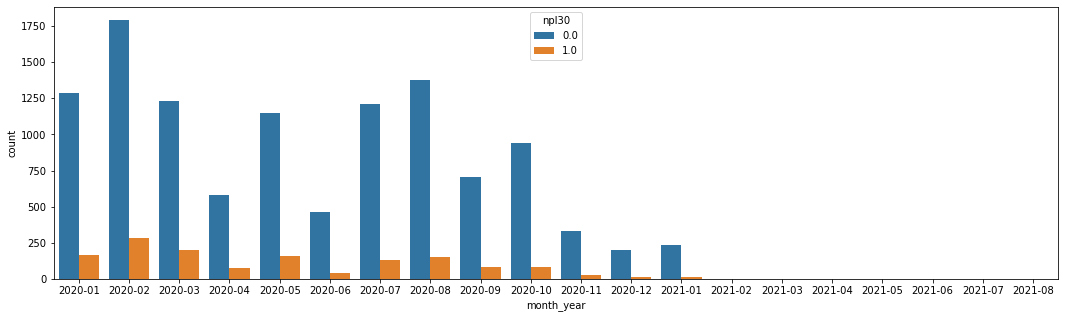

In [25]:
import seaborn as sns

df['week_year'] = df['date_requested'].apply(lambda x: x.strftime('%Y-%W'))
df['month_year'] = df['date_requested'].apply(lambda x: x.strftime('%Y-%m'))

plt.figure(figsize=(18, 5))
sns.countplot(x='month_year', hue='npl30', data=df)

In [26]:
# Граница по дате для train/test выборки
date_tt = np.datetime64('2020-10-01')
df['sample_type'] = df['date_requested'].apply(lambda x: 'train' if x < date_tt else 'test')
df['date_requested'].apply(lambda x: 'train' if x < date_tt else 'test').value_counts()

train    11091
test      6329
Name: date_requested, dtype: int64

In [27]:
df_train = df.drop(df[df['npl1'].isna()].index)[df['sample_type']=='train'].copy()
df_test = df.drop(df[df['npl1'].isna()].index)[df['sample_type']=='test'].copy()

df_npl1 = df.drop(df[df['npl1'].isna()].index).copy()
df_npl30 = df.drop(df[df['npl30'].isna()].index).copy()

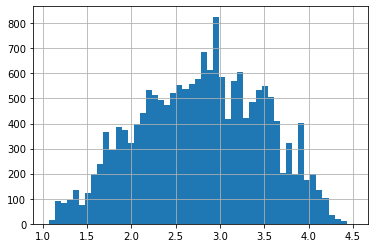

In [28]:
df['score_model'].hist(bins=50)

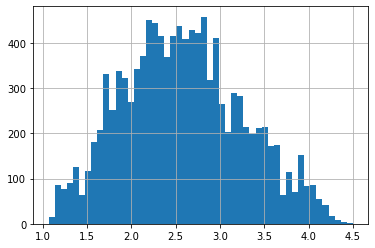

In [29]:
df_train['score_model'].hist(bins=50)

In [30]:
sb = 10

bin_val = [df_train['score_model'].quantile(i/sb) for i in range(0,sb+1)]
bin_val[0] = df['score_model'].min()
bin_val[-1] = df['score_model'].max()
bin_name = [float('{:.3f}'.format(df_train['score_model'].quantile(i/sb))) for i in range(1,sb+1)]

df['score_bucket'] = pd.cut(df['score_model'], bins=bin_val, labels=bin_name, include_lowest=True)

In [31]:
df['npl1P_flg'] = df['npl1'].apply(lambda x: 1 if x > 0 else 0)
df['npl30P_flg'] = df['npl30'].apply(lambda x: 1 if x > 0 else 0)

In [32]:
# pivot = pd.pivot_table(df[df['sample_type']=='train'],  # Для тестирования калибровки
pivot = pd.pivot_table(df[df['npl30'].isna() == False],  # Для построения итоговой модели
               index=['score_bucket'],
               values=['score_model', 'credit_id', 'npl1', 'npl30'],
               aggfunc={'score_model': np.mean, 'credit_id': len, 'npl1': np.mean, 'npl30': np.mean})
pivot.rename(columns={'score_model':'score_model_avg', 'credit_id': 'credit_id_cnt',\
                      'npl1':'npl1_avg', 'npl30': 'npl30_avg'}, inplace=True)

pivot['score_bucket'] = pivot.index
pivot.index = range(0, pivot.shape[0])
pivot = pivot[['score_bucket', 'score_model_avg', 'credit_id_cnt', 'npl1_avg', 'npl30_avg' ]]

pivot['ln(odds)_npl1P'] = pivot['npl1_avg'].apply(lambda x: math.log(((1-x)/x), math.e) if x > 0.001 else 0)
pivot['ln(odds)_npl30P'] = pivot['npl30_avg'].apply(lambda x: math.log(((1-x)/x), math.e) if x > 0.001 else 0)

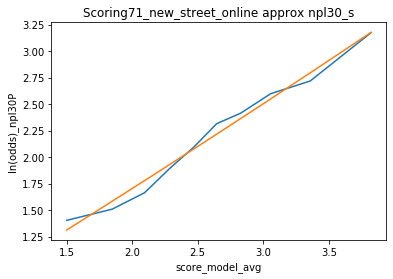

In [33]:
x = pivot['score_model_avg'].values
y = pivot['ln(odds)_npl30P'].values
#полином 1 степени по функции
p = np.polyfit(x, y, 2)
#подставляем значения x к полученному полиному
ya = np.polyval(p, x)

plt.plot(x, y)
plt.plot(x, ya)
plt.title(card_name + ' approx npl30_s', fontsize=12)
plt.xlabel('score_model_avg')
plt.ylabel('ln(odds)_npl30P')
plt.savefig('pic/' + card_name + '_npl30_s_approx.png')
plt.show()

In [34]:
df['PD_calib_npl30P'] = df['score_model'].apply(lambda x: (1/(1+math.exp((p[2] + p[1]*x + p[0]*(x**2))))))
# df['PD_calib_npl30P'] = df['score_model'].apply(lambda x: (1/(1+math.exp((p[1] + p[0]*x)))))
p_30 = p

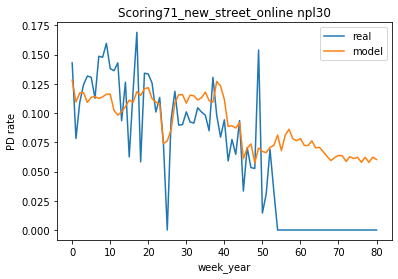

In [35]:
pivot_gr_1 = pd.pivot_table(df, #[df['npl30'].isna() == False],
                          index = ['week_year'],
                          values = ['npl30P_flg', 'PD_calib_npl30P'],
                          aggfunc = np.mean)

pivot_gr_1.index = range(0, pivot_gr_1.shape[0])
plt.plot(pivot_gr_1.index, pivot_gr_1['npl30P_flg'], label='real')
plt.plot(pivot_gr_1.index, pivot_gr_1['PD_calib_npl30P'], label='model')
plt.title(card_name + ' npl30', fontsize=12)
plt.xlabel('week_year')
plt.ylabel('PD rate')
plt.savefig('pic/' + card_name + '_npl30.png')
plt.legend()
plt.show()

In [36]:
# df_test = df[df['date_requested'] >= pd.to_datetime('2021-06-01')]
df_test['PD_calib_npl30P'] = df_test['score_model'].apply(lambda x: (1/(1+math.exp((p[2] + p[1]*x + p[0]*(x**2))))))
# df_test['PD_calib_npl30P'] = df_test['score_model'].apply(lambda x: (1/(1+math.exp((p[1] + p[0]*x)))))


pivot_gr_test30 = pd.pivot_table(df_test,
                          index = ['week_year'],
                          values = ['npl30', 'PD_calib_npl30P'],
                          aggfunc = np.mean)
pivot_gr_test30.drop(pivot_gr_test30[pivot_gr_test30['npl30'].isna()].index, inplace=True)
np.sum((pivot_gr_test30['PD_calib_npl30P'] - pivot_gr_test30['npl30']).values ** 2)

0.017299217366004434

In [37]:
# pivot = pd.pivot_table(df[df['sample_type']=='train'],  # Для тестирования калибровки
pivot = pd.pivot_table(df[df['npl1'].isna() == False],  # Для построения итоговой модели
               index=['score_bucket'],
               values=['score_model', 'credit_id', 'npl1', 'npl30'],
               aggfunc={'score_model': np.mean, 'credit_id': len, 'npl1': np.mean, 'npl30': np.mean})
pivot.rename(columns={'score_model':'score_model_avg', 'credit_id': 'credit_id_cnt',\
                      'npl1':'npl1_avg', 'npl30': 'npl30_avg'}, inplace=True)

pivot['score_bucket'] = pivot.index
pivot.index = range(0, pivot.shape[0])
pivot = pivot[['score_bucket', 'score_model_avg', 'credit_id_cnt', 'npl1_avg', 'npl30_avg' ]]

pivot['ln(odds)_npl1P'] = pivot['npl1_avg'].apply(lambda x: math.log(((1-x)/x), math.e) if x > 0.001 else 0)
pivot['ln(odds)_npl30P'] = pivot['npl30_avg'].apply(lambda x: math.log(((1-x)/x), math.e) if x > 0.001 else 0)

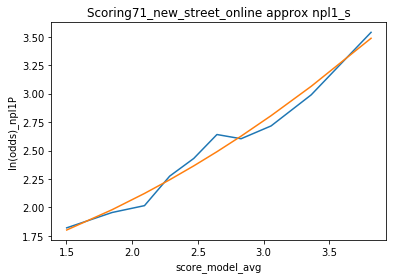

In [38]:
x = pivot['score_model_avg'].values
y = pivot['ln(odds)_npl1P'].values
#полином 1 степени по функции
p = np.polyfit(x, y, 2)
#подставляем значения x к полученному полиному
ya = np.polyval(p, x)

plt.plot(x, y)
plt.plot(x, ya)
plt.title(card_name + ' approx npl1_s', fontsize=12)
plt.xlabel('score_model_avg')
plt.ylabel('ln(odds)_npl1P')
plt.savefig('pic/' + card_name + '_npl1_s_approx.png')
plt.show()

In [39]:
df['PD_calib_npl1P'] = df['score_model'].apply(lambda x: (1/(1+math.exp((p[2] + p[1]*x + p[0]*(x**2))))))
# df['PD_calib_npl3P'] = df['score_model'].apply(lambda x: (1/(1+math.exp((p[1] + p[0]*x)))))
p_1 = p

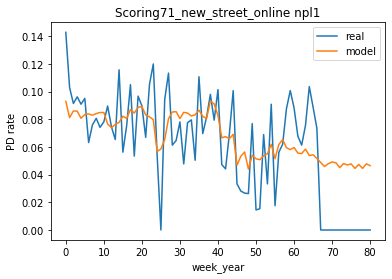

In [40]:
pivot_gr_1 = pd.pivot_table(df, #[df['npl1'].isna() == False],
                          index = ['week_year'],
                          values = ['npl1P_flg', 'PD_calib_npl1P'],
                          aggfunc = np.mean)

pivot_gr_1.index = range(0, pivot_gr_1.shape[0])
plt.plot(pivot_gr_1.index, pivot_gr_1['npl1P_flg'], label='real')
plt.plot(pivot_gr_1.index, pivot_gr_1['PD_calib_npl1P'], label='model')
plt.title(card_name + ' npl1', fontsize=12)
plt.xlabel('week_year')
plt.ylabel('PD rate')
plt.savefig('pic/' + card_name + '_npl1.png')
plt.legend()
plt.show()

In [41]:
# df_test = df[df['date_requested'] >= pd.to_datetime('2021-06-01')]
df_test['PD_calib_npl1P'] = df_test['score_model'].apply(lambda x: (1/(1+math.exp((p[2] + p[1]*x + p[0]*(x**2))))))
# df_test['PD_calib_npl30P'] = df_test['score_model'].apply(lambda x: (1/(1+math.exp((p[1] + p[0]*x)))))


pivot_gr_test1 = pd.pivot_table(df_test,
                          index = ['week_year'],
                          values = ['npl1', 'PD_calib_npl1P'],
                          aggfunc = np.mean)
pivot_gr_test1.drop(pivot_gr_test1[pivot_gr_test1['npl1'].isna()].index, inplace=True)
np.sum((pivot_gr_test1['PD_calib_npl1P'] - pivot_gr_test1['npl1']).values ** 2)

0.020746247125324392

In [43]:
p

array([0.10734793, 0.15757883, 1.32209684])

In [47]:
p_30

array([0.01083978, 0.74580587, 0.16962822])

In [51]:
df['Scoring71_new'].apply(lambda x: score_model(x)).apply(lambda x: 1.63899673596737 + -0.123791226167742*x + 0.166360021*(x**2) 
                        ).apply(lambda x: 1 / (1 + math.exp(x))).mean()

0.07304463133548826

In [257]:
writer = pd.ExcelWriter(card_name + '.xlsx', engine='xlsxwriter')


df_base.to_excel(writer, sheet_name='Data')

workbook  = writer.book
worksheet = workbook.add_worksheet('Calib_info')
bold = workbook.add_format({'bold': True})
percent_fmt = workbook.add_format({'num_format': '0.00%'})

worksheet.write('A1', 'x_calib = a*x^2 + b*x + c')
worksheet.write('B3', 'a')
worksheet.write('C3', 'b')
worksheet.write('D3', 'c')

worksheet.write('A4', 'npl1')
worksheet.write('A5', 'npl30')

worksheet.write('B4', p_1[0])
worksheet.write('C4', p_1[1])
worksheet.write('D4', p_1[2])

worksheet.write('B5', p_30[0])
worksheet.write('C5', p_30[1])
worksheet.write('D5', p_30[2])


worksheet.insert_image('E1', 'pic/' + card_name + '_npl1_s_approx.png')
worksheet.insert_image('N1','pic/' + card_name + '_npl30_s_approx.png')
worksheet.insert_image('E21', 'pic/' + card_name + '_npl1.png')
worksheet.insert_image('N21','pic/' + card_name + '_npl30.png')
writer.save()
writer.close()